In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import time 
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import zipfile 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import keras

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


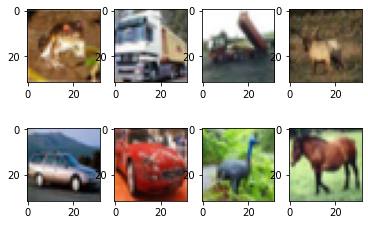

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

Our first model is a basic CNN structure, which contains two 2D convolutional layers, two max pooling layer, two dropout layer, a flatten layer, two dense layer and the classficication layer. It is trained on the noisy data.

For the optimizer, we use Nadam and set learning rate as 0.001.

In [7]:
import sys
import os
sys.path.insert(1, '../lib')

from model1 import *

if "modelI" in os.listdir("../output/"):
    modelI = tf.keras.models.load_model("../output/modelI")
else:
    # Create modelI using all 50,000 imgs and noisy labels
    modelI, history = create_model_I(imgs, noisy_labels,0.2, 6)

In [8]:
modelI.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                 

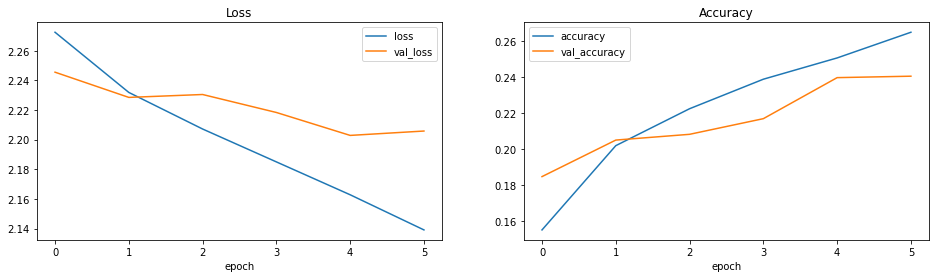

In [9]:
# Plot the training history

metrics_df = pd.read_csv('history_model1.csv')
fig, ax = plt.subplots(1,2,figsize=(16,4))
metrics_df[["loss","val_loss"]].plot(ax=ax[0]);
ax[0].set_xlabel("epoch");
ax[0].set_title("Loss");
metrics_df[["accuracy","val_accuracy"]].plot(ax=ax[1]);
ax[1].set_xlabel("epoch");
ax[1].set_title("Accuracy");

In [10]:
# Test the model on 10,000 clean labels (for general approximation)
# Returns approximately 55.27% 

test_model_I(imgs[:10000], clean_labels, modelI)

0.5527

In [11]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    #reshape image into rank 4 tensor
    #takes in one image of (32, 32, 3) and returns label prediction

    image = tf.reshape(image, ((1,) + image.shape))
    predictions = modelI.predict(image)
    
    return np.argmax(predictions)

In [12]:
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [13]:
start = time.time()
evaluation(model_I, clean_labels[:1000], imgs[:1000])
end = time.time()

print("--- model took %s seconds ---" % (end-start))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       102
           1       0.72      0.73      0.73       112
           2       0.40      0.54      0.46        99
           3       0.31      0.70      0.43        92
           4       0.42      0.39      0.41        99
           5       0.74      0.29      0.42        85
           6       0.74      0.46      0.57       107
           7       0.77      0.53      0.63       102
           8       0.78      0.71      0.74        99
           9       0.64      0.66      0.65       103

    accuracy                           0.56      1000
   macro avg       0.62      0.56      0.56      1000
weighted avg       0.62      0.56      0.57      1000

--- model took 21.131603956222534 seconds ---


### 2.3. Model II

In [14]:
import sys
import os
sys.path.insert(1, '../lib')

from model2 import *

if "modelII" in os.listdir("../output/"):
    modelII = tf.keras.models.load_model("../output/modelII")
else:
    # Create modelII instance, held aside 1000 clean images for testing
    modelII, history = create_model_II(imgs[1000:10000], clean_labels[1000:10000], noisy_labels[1000:10000], imgs[10000:], noisy_labels[10000:], 0.2, epochs1=100, epochs2=100)

In [15]:
modelII.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

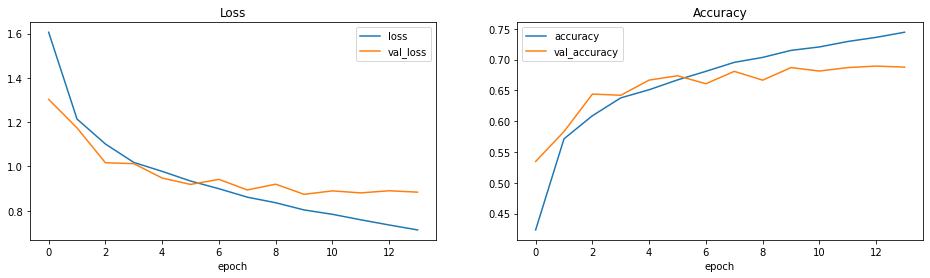

In [16]:
# Plot the training history

metrics_df = pd.read_csv('history_model2.csv')
fig, ax = plt.subplots(1,2,figsize=(16,4))
metrics_df[["loss","val_loss"]].plot(ax=ax[0]);
ax[0].set_xlabel("epoch");
ax[0].set_title("Loss");
metrics_df[["accuracy","val_accuracy"]].plot(ax=ax[1]);
ax[1].set_xlabel("epoch");
ax[1].set_title("Accuracy");

In [17]:
test_model_II(imgs[:1000], clean_labels[:1000], modelII)

0.657

In [18]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    image = tf.reshape(image, ((1,) + image.shape))
    predictions = modelII.predict(image)
    
    return np.argmax(predictions)

In [19]:
start = time.time()
evaluation(model_II, clean_labels[:1000], imgs[:1000])
end = time.time()

print("--- model took %s seconds ---" % (end-start))

              precision    recall  f1-score   support

           0       0.77      0.60      0.67       102
           1       0.89      0.76      0.82       112
           2       0.50      0.63      0.56        99
           3       0.45      0.58      0.50        92
           4       0.58      0.53      0.55        99
           5       0.61      0.27      0.37        85
           6       0.66      0.80      0.72       107
           7       0.63      0.77      0.70       102
           8       0.79      0.78      0.79        99
           9       0.77      0.77      0.77       103

    accuracy                           0.66      1000
   macro avg       0.66      0.65      0.65      1000
weighted avg       0.67      0.66      0.65      1000

--- model took 21.62440586090088 seconds ---


## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [20]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

#### Baseline Model

In [ ]:
start = time.time()
evaluation(baseline_model, y_test, x_test)
end = time.time()

print("--- model took %s seconds ---" % (end-start))

#### Model I

In [ ]:
start = time.time()
evaluation(model_I, y_test, x_test)
end = time.time()

print("--- model took %s seconds ---" % (end-start))

#### Model II

In [ ]:
start = time.time()
evaluation(model_II, y_test, x_test)
end = time.time()

print("--- model took %s seconds ---" % (end-start))

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.